In [1]:
import random
import itertools as it
import time

import pandas as pd
import numpy as np
np.random.seed(1337)


dataset_A = pd.read_csv('../TSPA.csv', sep=';', names=['x', 'y', 'cost'])
dataset_B = pd.read_csv('../TSPB.csv', sep=';', names=['x', 'y', 'cost'])

datasets = [dataset_A, dataset_B]

dataset_A.shape, dataset_B.shape

((200, 3), (200, 3))

In [2]:
node1, node2 = dataset_B.iloc[177], dataset_B.iloc[43]

print(f'{node1}\n\n{node2}')

x       1450
y        398
cost      52
Name: 177, dtype: int64

x       1654
y       1486
cost     638
Name: 43, dtype: int64


In [3]:
def euclidean_distance(node1, node2):
    return np.int32(((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2) ** 0.5 + 0.5)

In [4]:
print(f'distance between node1 and node2 = {euclidean_distance(node1, node2)}')

distance between node1 and node2 = 1107


In [5]:
def nodes_cost(node1, node2):
    return node1['cost'] + node2['cost']

In [6]:
print(f'objective function of node1 and node2 = {euclidean_distance(node1, node2) + nodes_cost(node1, node2)}')

objective function of node1 and node2 = 1797


In [7]:
def calculate_function_cost(dataset):
    node_cost = dataset["cost"].sum()
    distance_cost = sum(
        euclidean_distance(dataset.iloc[i], dataset.iloc[i + 1]) 
        for i in range(-1, len(dataset) - 1)
    )
    return int(node_cost + distance_cost)

In [8]:
def calculate_distance_matrix(dataset):
    n_nodes = len(dataset)
    distance_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float64)
    for i, j in it.product(range(n_nodes), range(n_nodes)):
        if i == j:
            continue
        a, b = dataset.iloc[i], dataset.iloc[j]
        distance_matrix[i, j] = euclidean_distance(a, b) + nodes_cost(a, b)
    return distance_matrix

In [9]:
distance_matrix_A = calculate_distance_matrix(dataset_A)
distance_matrix_B = calculate_distance_matrix(dataset_B)

In [10]:
print(f'objective function of node1 and node2 = {distance_matrix_A[177, 43]}')

objective function of node1 and node2 = 1831.0


In [11]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot(dataset, solution, title):
    max_x = dataset['x'].max()
    max_y = dataset['y'].max()

    aspect_ratio = int(max_x / max_y)

    if max_x > max_y:
        height = 6.0
        width = height * aspect_ratio
    else:
        width = 6.0
        height = width * aspect_ratio

    sns.set_theme(rc={'figure.figsize': (width, height)})

    sns.scatterplot(
        data=dataset,
        x='x',
        y='y',
        size='cost',
        legend=False
    )

    for i in range(-1, len(solution) - 1):
        idx1 = solution[i]
        idx2 = solution[i + 1]
        x_values = [dataset.loc[idx1, "x"], dataset.loc[idx2, "x"]]
        y_values = [dataset.loc[idx1, "y"], dataset.loc[idx2, "y"]]
        plt.plot(
            x_values,
            y_values,
            color="b",
            linestyle="-",
        )
    

    
    plt.title(title)
    plt.show();

In [12]:
def experiment(dataset, distance_matrix, title, function, show_indices=False, **kwargs):
    start_time = time.time()
    ratings = []
    for i in range(200):
        greedy_cycle_solution = function(dataset, distance_matrix, i, **kwargs)
        solution = list(greedy_cycle_solution.index)
        ratings.append((solution, calculate_function_cost(greedy_cycle_solution)))

        if show_indices:
            print(i)

    best = sorted(ratings, key=lambda x: x[1])[0]
    minimum = sorted(ratings, key=lambda x: x[1])[0][1]
    mean = sum([obj_function for _, obj_function in ratings]) / len(ratings)
    maximum = sorted(ratings, key=lambda x: x[1])[-1][1]
    end_time = time.time()

    print(f"Best solution: {best[0]}")
    print(f"Time to calculate: {(end_time - start_time):.4f}")
    print("Objective function statistics:")
    print(f"{minimum = }\n{mean = }\n{maximum = }")
    plot(dataset, best[0], title=title)

# Local Search



In [13]:
def init_random_solution(dataset: pd.DataFrame, distance_matrix: pd.DataFrame, start: int) -> pd.DataFrame:
    return dataset.sample(n=int(len(dataset) * 0.5 + 0.5))

In [14]:
def init_greedy_cycle(dataset: pd.DataFrame, distance_matrix: pd.DataFrame, start: int) -> pd.Series:
    size = int(len(dataset) * 0.5 + 0.5)
    num_nodes = len(dataset)

    distance_matrix = distance_matrix.copy()

    remaining_nodes = set(range(num_nodes))
    remaining_nodes.remove(start)
    solution = [start]

    nearest_node = np.argmin(distance_matrix[start, list(remaining_nodes)])
    nearest_node_idx = list(remaining_nodes)[nearest_node]
    solution.append(nearest_node_idx)
    remaining_nodes.remove(nearest_node_idx)

    while len(solution) < size:
        best_insertion_cost = float("inf")
        best_insertion = None

        for node_idx in remaining_nodes:
            for i in range(len(solution)):
                next_i = (i + 1) % len(solution)

                current_cost = (
                    distance_matrix[solution[i], node_idx]
                    + distance_matrix[node_idx, solution[next_i]]
                    - distance_matrix[solution[i], solution[next_i]]
                )

                if current_cost < best_insertion_cost:
                    best_insertion_cost = current_cost
                    best_insertion = (node_idx, i)

        solution.insert(best_insertion[1] + 1, best_insertion[0])
        remaining_nodes.remove(best_insertion[0])

    return dataset.loc[solution]

In [15]:
def calculate_candidates(dataset: pd.DataFrame, distance_matrix: np.ndarray, solution: list, k: int) -> dict:
    solution_indices = solution if isinstance(solution[0], int) else list(solution)
    
    submatrix = distance_matrix[np.ix_(solution_indices, solution_indices)]
    
    candidates = {}
    for i, node in enumerate(solution_indices):
        distances = submatrix[i]
        nearest_neighbors = np.argsort(distances)[:k + 1]  
        nearest_neighbors = nearest_neighbors[nearest_neighbors != i] 
        
        candidates[node] = set(solution_indices[idx] for idx in nearest_neighbors)
    
    return candidates

def objective_change_two_nodes(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i == j:
        return 0.0

    n = len(solution)
    a, b = solution[i], solution[j]

    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a_next = solution[(i + 1) % n]
    b_prev = solution[j - 1] if j > 0 else solution[-1]
    b_next = solution[(j + 1) % n]

    # Edges to be removed and added
    edges_removed = []
    edges_added = []

    # Remove edges connected to a and b
    if a_prev not in (a, b):
        edges_removed.append((a_prev, a))
        edges_added.append((a_prev, b))
    if a_next not in (a, b):
        edges_removed.append((a, a_next))
        edges_added.append((b, a_next))
    if b_prev not in (a, b):
        edges_removed.append((b_prev, b))
        edges_added.append((b_prev, a))
    if b_next not in (a, b):
        edges_removed.append((b, b_next))
        edges_added.append((a, b_next))

    # Calculate delta
    delta = -sum(dm[u, v] for u, v in edges_removed) + sum(
        dm[u, v] for u, v in edges_added
    )

    return delta


def objective_change_two_edges(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i >= j or (i == 0 and j == len(solution) - 1):
        return 0.0

    n = len(solution)
    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a = solution[i]
    b = solution[j]
    b_next = solution[(j + 1) % n]

    # Edges before and after reversal
    cost_before = dm[a_prev, a] + dm[b, b_next]
    cost_after = dm[a_prev, b] + dm[a, b_next]

    delta = cost_after - cost_before

    return delta


def objective_change_inter_route(
    dm: np.ndarray, solution: list, i: int, vacant_node: int, node_costs: list
) -> float:
    n = len(solution)
    node_in_solution = solution[i]
    prev_node = solution[i - 1] if i > 0 else solution[-1]
    next_node = solution[(i + 1) % n]

    # Edge costs before and after the swap
    edge_cost_before = dm[prev_node, node_in_solution] + dm[node_in_solution, next_node]
    edge_cost_after = dm[prev_node, vacant_node] + dm[vacant_node, next_node]

    # Node costs before and after the swap
    node_cost_before = node_costs[node_in_solution]
    node_cost_after = node_costs[vacant_node]

    delta = (edge_cost_after - node_cost_after) - (edge_cost_before - node_cost_before)

    return delta


def two_nodes_exchange(solution: list, i: int, j: int) -> list:
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution


def two_edges_exchange(solution: list, i: int, j: int) -> list:
    if i >= j:
        return solution.copy()  # No change if i >= j

    new_solution = solution.copy()
    new_solution[i : j + 1] = new_solution[i : j + 1][::-1]
    return new_solution


def inter_route_swap(solution, i, vacant_node, selected_nodes, non_selected_nodes):
    new_solution = solution.copy()
    node_in_solution = new_solution[i]
    new_solution[i] = vacant_node

    # Update the node sets
    selected_nodes = selected_nodes.copy()
    non_selected_nodes = non_selected_nodes.copy()

    selected_nodes.remove(node_in_solution)
    selected_nodes.add(vacant_node)
    non_selected_nodes.remove(vacant_node)
    non_selected_nodes.add(node_in_solution)

    return new_solution, selected_nodes, non_selected_nodes


def get_remaining_nodes(selected_nodes: set, num_nodes: int) -> set:
    return set(range(num_nodes)) - selected_nodes


def browse_intra_solutions(dm: np.ndarray, solution: list, candidates: dict, intra_search: str) -> tuple:
    intra_neighbors = []
    n = len(solution)
    for i in range(n):
        valid_candidates = [j for j in candidates[solution[i]] if j in solution]
        
        for j in valid_candidates:
            if intra_search == "node":
                delta_nodes = objective_change_two_nodes(dm, solution, i, solution.index(j))
                if delta_nodes < 0:
                    intra_neighbors.append((i, solution.index(j), delta_nodes, "node"))
            elif intra_search == "edge":
                delta_edges = objective_change_two_edges(dm, solution, i, solution.index(j))
                if delta_edges < 0:
                    intra_neighbors.append((i, solution.index(j), delta_edges, "edge"))
    
    return intra_neighbors


def browse_inter_solutions(dm: np.ndarray, solution: list, non_selected_nodes: set, costs: list, candidates: dict) -> list:
    inter_neighbors = []
    for i in range(len(solution)):
        valid_candidates = [j for j in candidates[solution[i]] if j not in solution]
        
        for vacant_node in valid_candidates:
            inter_delta = objective_change_inter_route(
                dm, solution, i, vacant_node, costs
            )
            if inter_delta < 0:
                inter_neighbors.append((i, vacant_node, inter_delta, "inter"))
    return inter_neighbors

def update_solution(
    solution: list,
    best_neighbor: tuple,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    neighbor_type = best_neighbor[-1]

    if neighbor_type == "node":
        i, j = best_neighbor[:2]
        solution = two_nodes_exchange(solution, int(i), int(j))
    elif neighbor_type == "edge":
        i, j = best_neighbor[:2]
        solution = two_edges_exchange(solution, int(i), int(j))
    elif neighbor_type == "inter":
        i, vacant_node = best_neighbor[:2]
        solution, selected_nodes, non_selected_nodes = inter_route_swap(
            solution, int(i), int(vacant_node), selected_nodes, non_selected_nodes
        )
    return solution, selected_nodes, non_selected_nodes


def local_search(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    initial_solution: list,
    k: int,
    strategy: str = "greedy",
    intra_search: str = "edge",
    debug_mode: bool = True,
) -> pd.DataFrame:
    num_nodes = len(distance_matrix)
    initial_cost = calculate_function_cost(dataset.loc[initial_solution])

    solution = initial_solution.copy()
    selected_nodes = set(initial_solution)
    non_selected_nodes = get_remaining_nodes(selected_nodes, num_nodes)

    candidates = calculate_candidates(dataset, distance_matrix, solution, k)

    while True:
        intra_neighbors = browse_intra_solutions(distance_matrix, solution, candidates, intra_search)
        inter_neighbors = browse_inter_solutions(distance_matrix, solution, non_selected_nodes, dataset["cost"].tolist(), candidates)

        all_neighbors = intra_neighbors + inter_neighbors

        if not all_neighbors:
            # No improvement found
            break

        if strategy == "greedy":
            random.shuffle(all_neighbors)
            best_neighbor = next((n for n in all_neighbors if n[2] < 0), None)
        elif strategy == "steepest":
            best_neighbor = min(all_neighbors, key=lambda x: x[2])

        if best_neighbor is None:
            # No improving neighbor found
            break

        # Save the old solution for debugging
        old_solution = solution.copy()

        # Update solution and cost
        solution, selected_nodes, non_selected_nodes = update_solution(
            solution, best_neighbor, selected_nodes, non_selected_nodes
        )
        initial_cost += best_neighbor[2]

        if debug_mode:
            # Calculate real improvement
            real_improvement = calculate_function_cost(dataset.loc[old_solution]) - calculate_function_cost(
                dataset.loc[solution]
            )

            if real_improvement != -best_neighbor[2]:
                print(f"Promised improvement: {best_neighbor[2]}")
                print(f"Real improvement: {real_improvement}")
                print(f"Operation: {best_neighbor[-1]}")
                print("===========")

            assert calculate_function_cost(dataset.loc[solution]) < calculate_function_cost(dataset.loc[old_solution])

    return dataset.loc[solution]

In [16]:
def init_local_search(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    start: int,
    strategy: str,
    intra_search: str,
    k: int,
    debug_mode: bool = True,
    algo_to_enchance: str = "greedy_cycle",
) -> pd.DataFrame:
    if algo_to_enchance == "greedy_cycle":
        solution = list(init_greedy_cycle(dataset, distance_matrix, start).index)
    elif algo_to_enchance == "random":
        solution = list(init_random_solution(dataset, distance_matrix, start).index)
    solution = local_search(dataset, distance_matrix, solution, k, strategy, intra_search, debug_mode)
    return solution

In [17]:
algos = ["random", "greedy_cycle"]
intra_search = ["node", "edge"]
strategy = ["greedy", "steepest"]

Random steepest edge results for:

Dataset A

Best solution: [78, 145, 25, 44, 120, 129, 2, 75, 86, 101, 1, 152, 97, 26, 53, 180, 154, 135, 70, 127, 123, 131, 149, 162, 133, 151, 51, 118, 59, 116, 65, 47, 43, 184, 35, 84, 112, 4, 190, 10, 177, 54, 48, 34, 160, 42, 5, 115, 46, 139, 41, 193, 159, 181, 146, 22, 18, 108, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 148, 9, 62, 102, 49, 14, 144, 21, 164, 27, 90, 165, 40, 185, 106, 178, 52, 55, 57, 92, 179, 196, 81, 157, 31, 113, 175, 171, 16]

Time to calculate: 647.0512

Objective function statistics:

minimum = 71082

mean = 73892.495

maximum = 78058

Dataset B

Best solution: [20, 28, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 159, 41, 111, 82, 87, 21, 8, 104, 144, 0, 35, 109, 29, 160, 33, 138, 182, 11, 139, 168, 195, 145, 15, 189, 155, 3, 70, 161, 13, 132, 169, 188, 6, 134, 147, 51, 121, 90, 122, 133, 10, 107, 40, 63, 135, 38, 1, 117, 193, 31, 54, 73, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 79, 91, 141, 77, 81, 153, 187, 163, 89, 127, 103, 113, 180, 176, 194, 166, 86, 95, 185, 179, 94, 47, 148, 60, 23]

Time to calculate: 662.1826

Objective function statistics:

minimum = 45999

mean = 48257.715

maximum = 52107

### K = 10

Best solution: [135, 70, 158, 180, 173, 151, 79, 80, 176, 66, 60, 118, 116, 162, 161, 156, 4, 190, 177, 104, 184, 166, 28, 43, 42, 5, 96, 139, 191, 142, 193, 159, 192, 34, 103, 195, 22, 20, 108, 36, 93, 170, 143, 153, 183, 89, 83, 64, 15, 23, 137, 148, 37, 102, 144, 14, 21, 95, 164, 71, 27, 165, 106, 178, 3, 138, 32, 49, 167, 111, 87, 152, 97, 75, 2, 44, 16, 171, 175, 113, 56, 31, 157, 81, 187, 169, 196, 145, 78, 82, 92, 57, 52, 94, 63, 182, 189, 99, 121, 24]
Time to calculate: 470.1382
Objective function statistics:
minimum = 110644
mean = 130139.82
maximum = 144787


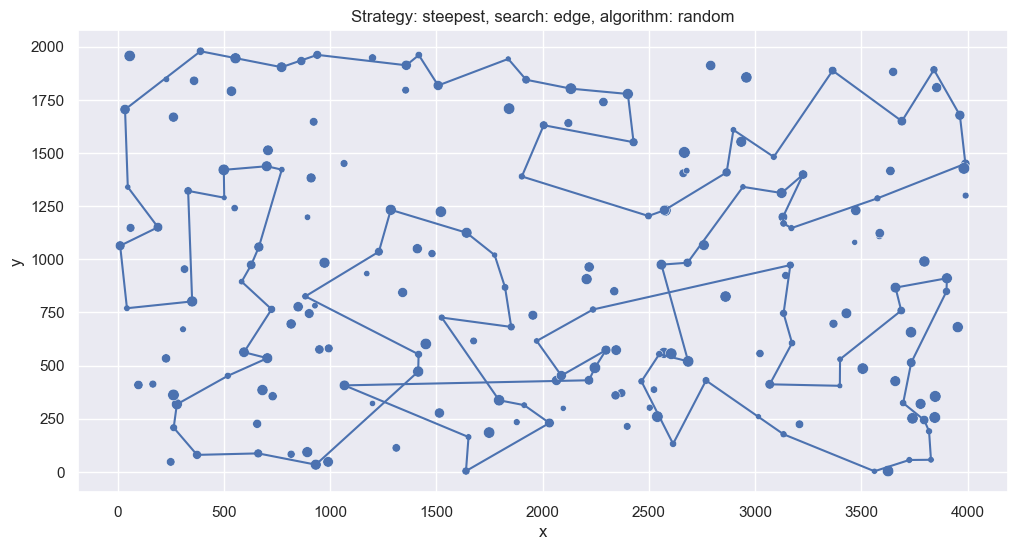

In [18]:
strat = 'steepest'
search = 'edge'
algo = 'random'

experiment(
    dataset_A,
    distance_matrix_A,
    f"Strategy: {strat}, search: {search}, algorithm: {algo}",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "k": 10,
    },
    show_indices = False,
)

Best solution: [80, 73, 164, 54, 31, 193, 30, 42, 198, 117, 151, 123, 177, 171, 157, 56, 144, 35, 109, 29, 11, 139, 182, 74, 51, 158, 25, 19, 1, 197, 92, 96, 17, 135, 131, 90, 191, 71, 115, 147, 134, 6, 188, 169, 126, 13, 161, 70, 3, 84, 167, 152, 53, 4, 28, 174, 34, 18, 83, 62, 128, 124, 159, 81, 163, 26, 113, 180, 176, 88, 194, 166, 86, 181, 95, 130, 148, 20, 23, 60, 154, 66, 179, 52, 48, 75, 127, 165, 97, 77, 58, 41, 111, 8, 21, 79, 61, 78, 45, 46]
Time to calculate: 608.2755
Objective function statistics:
minimum = 70858
mean = 78148.055
maximum = 88740


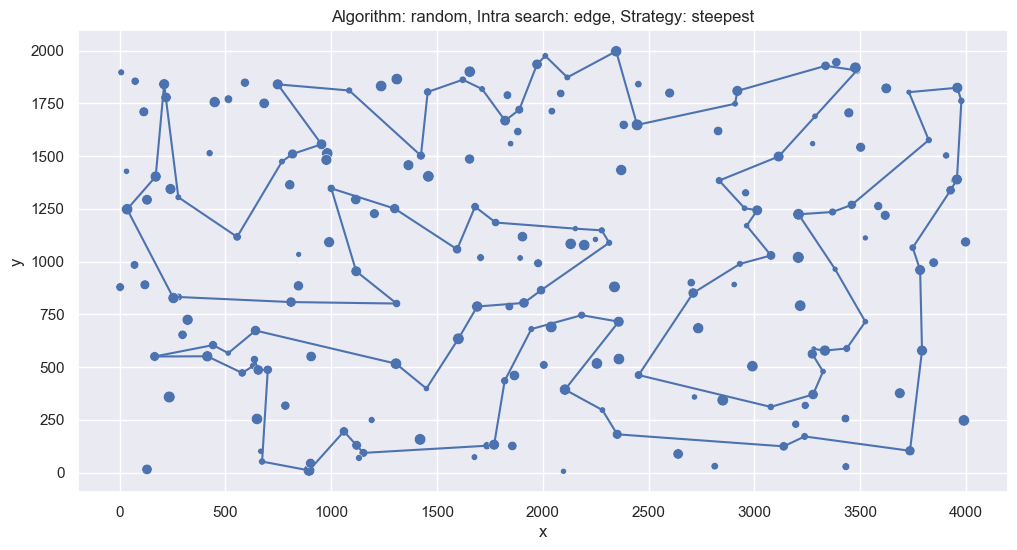

In [19]:
strat = 'steepest'
search = 'edge'
algo = 'random'

experiment(
    dataset_B,
    distance_matrix_B,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat}",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "k": 10,
    },
    show_indices = False,
)

### K = 20

Best solution: [164, 95, 107, 90, 165, 119, 40, 185, 196, 81, 98, 31, 13, 113, 175, 171, 16, 78, 145, 179, 91, 82, 120, 2, 75, 1, 26, 53, 158, 180, 121, 99, 189, 97, 152, 125, 167, 128, 57, 55, 52, 106, 138, 14, 144, 62, 9, 37, 137, 176, 80, 79, 151, 162, 161, 6, 127, 123, 156, 126, 4, 24, 149, 166, 28, 30, 104, 147, 181, 5, 96, 65, 197, 72, 109, 51, 141, 60, 46, 110, 193, 159, 195, 103, 22, 199, 69, 163, 67, 36, 140, 170, 143, 183, 89, 23, 186, 114, 21, 7]
Time to calculate: 502.5841
Objective function statistics:
minimum = 111099
mean = 124733.27
maximum = 143843


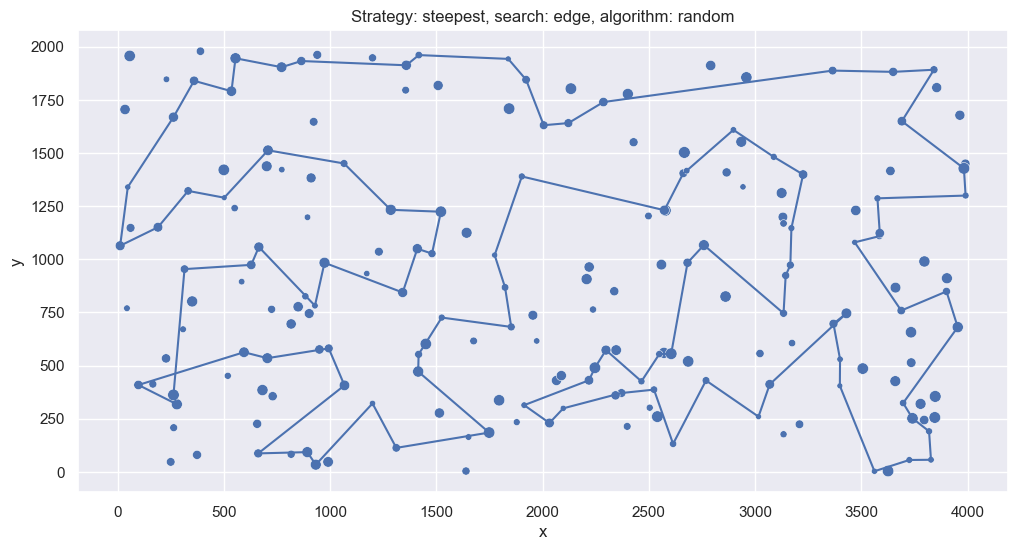

In [20]:
strat = 'steepest'
search = 'edge'
algo = 'random'

experiment(
    dataset_A,
    distance_matrix_A,
    f"Strategy: {strat}, search: {search}, algorithm: {algo}",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "k": 20,
    },
    show_indices = False,
)

Best solution: [169, 126, 13, 145, 15, 70, 3, 189, 155, 184, 170, 34, 35, 11, 139, 138, 33, 144, 56, 104, 8, 82, 50, 14, 81, 153, 106, 128, 62, 55, 181, 95, 185, 99, 9, 183, 149, 20, 23, 60, 148, 47, 94, 66, 172, 52, 48, 194, 113, 103, 137, 127, 163, 187, 146, 97, 77, 141, 21, 79, 61, 7, 5, 78, 162, 31, 193, 198, 196, 42, 156, 24, 1, 197, 27, 38, 63, 100, 72, 17, 10, 115, 178, 122, 32, 135, 131, 112, 19, 25, 116, 90, 71, 192, 134, 85, 98, 74, 43, 65]
Time to calculate: 541.3091
Objective function statistics:
minimum = 67096
mean = 73663.17
maximum = 80294


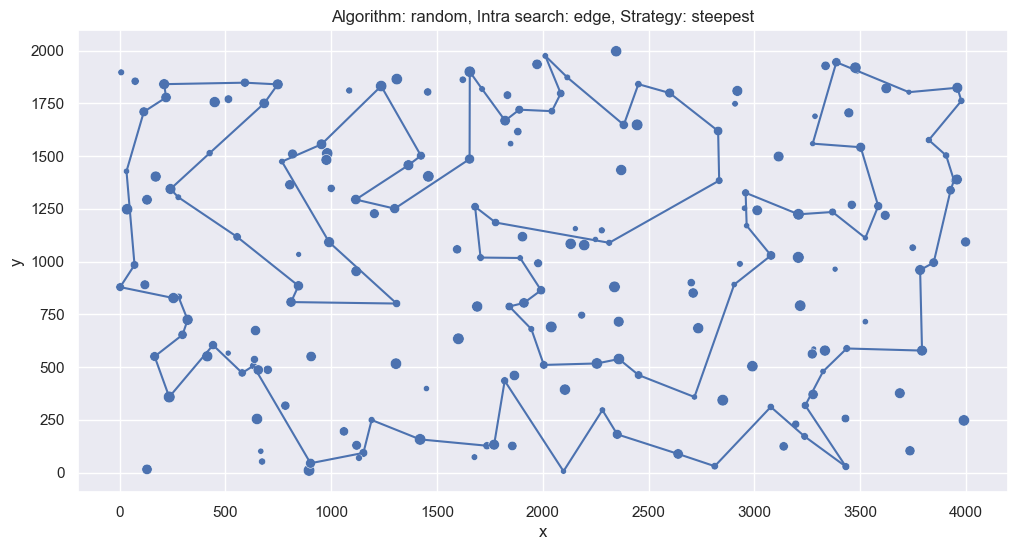

In [21]:
strat = 'steepest'
search = 'edge'
algo = 'random'

experiment(
    dataset_B,
    distance_matrix_B,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat}",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "k": 20,
    },
    show_indices = False,
)

### K = 50

Best solution: [136, 180, 154, 6, 70, 135, 133, 79, 63, 122, 176, 66, 141, 51, 109, 59, 118, 60, 46, 139, 115, 43, 47, 123, 127, 156, 112, 4, 84, 166, 184, 190, 10, 177, 54, 48, 34, 160, 192, 42, 5, 96, 193, 22, 199, 108, 36, 140, 93, 117, 153, 76, 186, 114, 15, 73, 132, 21, 7, 164, 58, 71, 95, 165, 138, 144, 9, 148, 167, 111, 124, 152, 172, 55, 3, 106, 185, 40, 187, 169, 196, 157, 188, 85, 113, 175, 13, 145, 92, 129, 82, 25, 120, 87, 97, 1, 101, 75, 86, 182]
Time to calculate: 493.0297
Objective function statistics:
minimum = 107286
mean = 121947.84
maximum = 133945


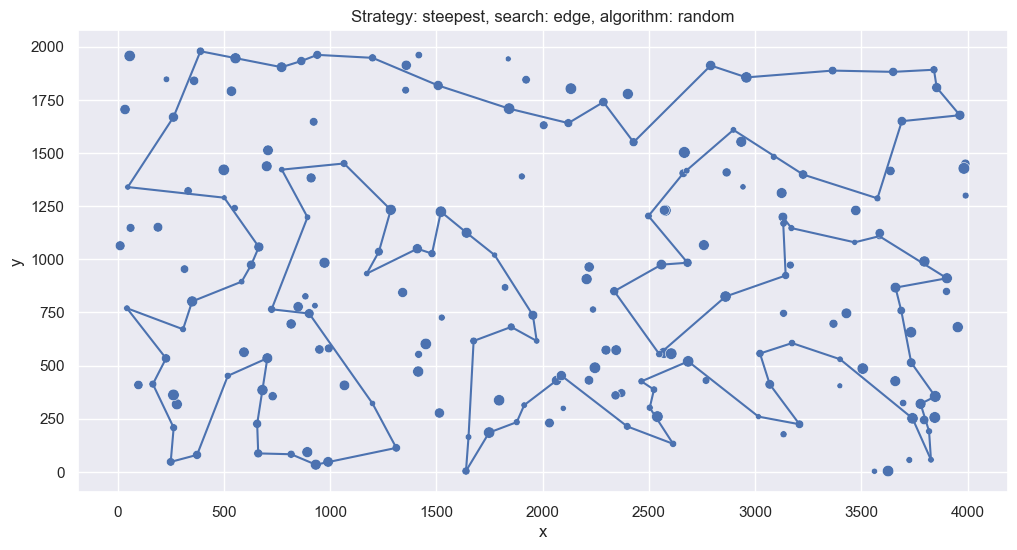

In [22]:
experiment(
    dataset_A,
    distance_matrix_A,
    f"Strategy: {strat}, search: {search}, algorithm: {algo}",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "k": 50,
    },
    show_indices = False,
)

Best solution: [64, 128, 62, 143, 119, 14, 50, 68, 111, 35, 109, 12, 39, 144, 160, 33, 49, 138, 11, 168, 195, 69, 189, 167, 155, 84, 15, 145, 13, 169, 188, 118, 125, 71, 10, 133, 44, 107, 100, 63, 96, 135, 38, 121, 158, 151, 198, 117, 54, 31, 164, 73, 190, 80, 46, 45, 142, 175, 78, 7, 123, 25, 157, 36, 91, 82, 58, 77, 97, 146, 153, 127, 137, 75, 114, 103, 26, 113, 88, 194, 166, 86, 185, 179, 57, 66, 148, 9, 140, 28, 4, 53, 152, 170, 34, 18, 55, 183, 95, 110]
Time to calculate: 478.0462
Objective function statistics:
minimum = 67557
mean = 73213.785
maximum = 79557


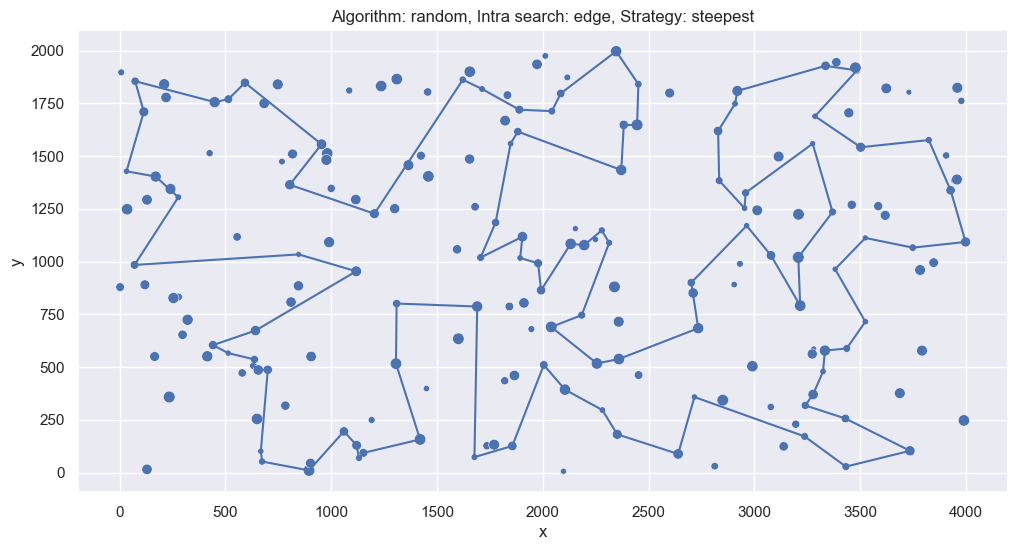

In [23]:
experiment(
    dataset_B,
    distance_matrix_B,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat}",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "k": 50,
    },
    show_indices = False,
)